In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import quad, trapz, simps
from scipy.stats import chisquare
from scipy.special import erfc
import Phisher
import camb
from camb import model, initialpower
from Bias_Scale_Class_perK import Cosmos
from scipy.optimize import curve_fit

%precision 4
%matplotlib inline

\begin{equation}
\large
F_{\alpha \beta} = \frac{1}{(2\pi)^2} \sum_{m, n}\sum_{l, i}\frac{\partial \ln P_{h}^{mn}(k_i, z_l)}{\partial p_{\alpha}} \frac{\partial \ln P_{h}^{mn}(k_i, z_l)}{\partial p_{\beta}} V^{mn}_{l i}k_i^2 \Delta k
\end{equation}

In [6]:
p = {'H0': 69.7, 'Omegab0': 0.02256/0.67**2, 'Omegam0': (0.1142+0.02256)/0.67**2, 'fnl': 5}

kmin, kmax, N = 1e-4, 0.2, 2500
Ks = np.linspace(kmin, kmax, N)
dK = Ks[333] - Ks[332]
zs = [0.1]
dp = 0.1

In [7]:
def fishing(ckwargs={},c1kwargs={},c2kwargs={},c3kwargs={}):
    print(list(ckwargs.keys())[0],list(c2kwargs.keys())[0])
    
    bScale_=False
    if (list(ckwargs.keys())[0]=='fnl' or list(c2kwargs.keys())[0]=='fnl'): 
        bScale_=True
        print('\tbScale =',bScale_)


    FXX = 0.0
    for z in zs:  
        print("\tz: ", z)
        for m in range(2):
            for n in range(2):
                print("\t\tm =",m," n =",n)

                c = Cosmos(z, *[kmin, kmax, N], **ckwargs)
                c.setPower()
                c.setMlim()

                c1 = Cosmos(z, *[kmin, kmax, N], **c1kwargs)
                c1.setPower()
                c1.setMlim()
                
                c2 = Cosmos(z, *[kmin, kmax, N], **c2kwargs)
                c2.setPower()
                c2.setMlim()

                c3 = Cosmos(z, *[kmin, kmax, N], **c3kwargs)
                c3.setPower()
                c3.setMlim()
                FXX += np.sum(c.dlnPhdp(m, n, c1, list(c1kwargs.values())[0]*dp, bScale_) * c2.dlnPhdp(m, n, c3, list(c3kwargs.values())[0]*dp, bScale_) * c.Veff_mn(m, n, bScale_)* Ks**2 * dK)
    
    print(FXX,'\n')
    return FXX

In [4]:
F00 = fishing({'H0':p['H0']+dp*p['H0']},{'H0':p['H0']},{'H0':p['H0']+dp*p['H0']},{'H0':p['H0']})
F01 = fishing({'H0':p['H0']+dp*p['H0']},{'H0':p['H0']},{'Omegab0':p['Omegab0']},{'Omegab0':p['Omegab0']+dp*p['Omegab0']})
F11 = fishing({'Omegab0':p['Omegab0']+dp*p['Omegab0']},{'Omegab0':p['Omegab0']},{'Omegab0':p['Omegab0']+dp*p['Omegab0']},{'Omegab0':p['Omegab0']})

H0 H0
	z:  0.1
		m = 0  n = 0
		m = 0  n = 1
		m = 1  n = 0
		m = 1  n = 1
5.820667623034063e-06 

H0 Omegab0
	z:  0.1
		m = 0  n = 0
		m = 0  n = 1
		m = 1  n = 0
		m = 1  n = 1
0.0029292847046613808 

Omegab0 Omegab0
	z:  0.1
		m = 0  n = 0
		m = 0  n = 1
		m = 1  n = 0
		m = 1  n = 1
1.8860214799956903 



In [21]:
F02 = fishing({'H0':p['H0']},{'H0':p['H0']+dp*p['H0']},{'Omegam0':p['Omegam0']},{'Omegam0':p['Omegam0']+dp*p['Omegam0']})
F12 = fishing({'Omegab0':p['Omegab0']},{'Omegab0':p['Omegab0']+dp*p['Omegab0']},{'Omegam0':p['Omegam0']},{'Omegam0':p['Omegam0']+dp*p['Omegam0']})
F22 = fishing({'Omegam0':p['Omegam0']},{'Omegam0':p['Omegam0']+dp*p['Omegam0']},{'Omegam0':p['Omegam0']},{'Omegam0':p['Omegam0']+dp*p['Omegam0']})

H0 Omegam0
	z:  0.1
		m = 0  n = 0
		m = 0  n = 1
		m = 1  n = 0
		m = 1  n = 1
0.0015405240315513463 

Omegab0 Omegam0
	z:  0.1
		m = 0  n = 0
		m = 0  n = 1
		m = 1  n = 0
		m = 1  n = 1
-0.8651237137443468 

Omegam0 Omegam0
	z:  0.1
		m = 0  n = 0
		m = 0  n = 1
		m = 1  n = 0
		m = 1  n = 1
0.48766710718685446 



In [ ]:
dp=0.1
F03 = fishing({'H0':p['H0']},{'H0':p['H0']+dp*p['H0']},{'fnl':p['fnl']},{'fnl':p['fnl']+dp*p['fnl']})
F13 = fishing({'Omegab0':p['Omegab0']},{'Omegab0':p['Omegab0']+dp*p['Omegab0']},{'fnl':p['fnl']},{'fnl':p['fnl']+dp*p['fnl']})
F23 = fishing({'Omegam0':p['Omegam0']},{'Omegam0':p['Omegam0']+dp*p['Omegam0']},{'fnl':p['fnl']},{'fnl':p['fnl']+dp*p['fnl']})
F33 = fishing({'fnl':p['fnl']},{'fnl':p['fnl']+dp*p['fnl']},{'fnl':p['fnl']},{'fnl':p['fnl']+dp*p['fnl']})

H0 fnl
	bScale = True
	z:  0.1
		m = 0  n = 0
bScale = True
			 Linear bias = 114.98173377153378
			 Linear bias = 115.27236479200539
			 Linear bias = 115.72401461626339
			 Linear bias = 116.42000311264276
			 Linear bias = 117.47878855738304
			 Linear bias = 119.05879114273277
			 Linear bias = 121.35257408238557
			 Linear bias = 124.56450956781107
			 Linear bias = 128.88862434903936
			 Linear bias = 134.542123493101
			 Linear bias = 141.83607929879108
			 Linear bias = 151.5412132064725
			 Linear bias = 166.55532672124906
			 Linear bias = 191.30880645948895
			 Linear bias = 234.4845071323394
			 Linear bias = 312.6082270285466
			 Linear bias = 459.7108020085566
			 Linear bias = 748.0901015105314
			 Linear bias = 1333.9813411335242
			 Linear bias = 2558.195248794419
			 Linear bias = 5165.036191598003
			 Linear bias = 10799.716215562727
			 Linear bias = 23154.88147004453
			 Linear bias = 50588.367234470374
			 Linear bias = 112156.75130625669
			 Linear bias = 251595.

			 Linear bias = 59.23512701811491
			 Linear bias = 83.41849475494035
			 Linear bias = 126.22376418730418
			 Linear bias = 204.11526321816987
			 Linear bias = 351.07649311835263
			 Linear bias = 639.3726399058471
			 Linear bias = 1225.2169953032587
			 Linear bias = 2449.405718299545
			 Linear bias = 5056.233830035188
			 Linear bias = 10690.907736297533
			 Linear bias = 23046.07050177444
			 Linear bias = 50479.555943229156
			 Linear bias = 112047.94141779773
			 Linear bias = 251486.2613637259
			 Linear bias = 569732.8895599825
			 Linear bias = 1300901.8795439375
			 Linear bias = 2990261.746010613
			 Linear bias = 6912586.562425765
			 Linear bias = 16058294.691903692
			 Linear bias = 37464263.60575485
			 Linear bias = 87740460.81342618
			 Linear bias = 206226029.60592756
			 Linear bias = 486503535.42490995
			 Linear bias = 1152713117.0816562
			 Linear bias = 2748050877.048779
			 Linear bias = 6615926656.396338
			 Linear bias = 16181969342.319126
			 Linear bias

			 Linear bias = 251473.1498111144
			 Linear bias = 569719.7842670577
			 Linear bias = 1300888.7852380844
			 Linear bias = 2990248.67072743
			 Linear bias = 6912573.519517415
			 Linear bias = 16058281.702825492
			 Linear bias = 37464250.70323899
			 Linear bias = 87740448.04292218
			 Linear bias = 206226017.01674512
			 Linear bias = 486503523.01275486
			 Linear bias = 1152713104.4339712
			 Linear bias = 2748050858.2809305
			 Linear bias = 6615926665.295928
			 Linear bias = 16181969365.880753
			 Linear bias = 40439492679.39224
			 Linear bias = 102376986291.37631
			 Linear bias = 249762146986.22675
			 Linear bias = 560053257818.7848
			 Linear bias = 1736547597899.0525
			 Linear bias = 3974462131304.4277
			 Linear bias = 9929520680651.467
			 Linear bias = 24333422958598.19
			 Linear bias = 81576502684742.83
			 Linear bias = 167822949698839.78
			 Linear bias = 399267721904608.75
			 Linear bias = 913681952123171.9
			 Linear bias = 2484685733076902.5
			 Linear bias

			 Linear bias = 16181969368.33669
			 Linear bias = 40439492683.65179
			 Linear bias = 102376986292.54448
			 Linear bias = 249762146950.3559
			 Linear bias = 560053257813.9279
			 Linear bias = 1736547597383.607
			 Linear bias = 3974462131293.4136
			 Linear bias = 9929520679978.814
			 Linear bias = 24333422965765.223
			 Linear bias = 81576502680918.11
			 Linear bias = 167822949709713.56
			 Linear bias = 399267721916579.8
			 Linear bias = 913681952097952.8
			 Linear bias = 2484685733037919.0
			 Linear bias = 6454823031143070.0
			 Linear bias = 1.5490461245656126e+16
			 Linear bias = 3.687874122120276e+16
			 Linear bias = 8.61158287669265e+16
			 Linear bias = 2.7526046615016192e+17
			 Linear bias = 5.7152478892172205e+17
			 Linear bias = 1.4848572221025157e+18
			 Linear bias = 3.51780184213538e+18
			 Linear bias = 7.161578022581802e+18
			 Linear bias = 2.2776333449019888e+19
			 Linear bias = 5.187919565700214e+19
			 Linear bias = 1.236706947804214e+20
			 Linear 

			 Linear bias = 6454823031066218.0
			 Linear bias = 1.5490461245658556e+16
			 Linear bias = 3.68787412210898e+16
			 Linear bias = 8.611582876734963e+16
			 Linear bias = 2.7526046614365674e+17
			 Linear bias = 5.71524788923747e+17
			 Linear bias = 1.4848572221027843e+18
			 Linear bias = 3.517801842132567e+18
			 Linear bias = 7.161578022580632e+18
			 Linear bias = 2.2776333449022353e+19
			 Linear bias = 5.187919565698166e+19
			 Linear bias = 1.2367069478042062e+20
			 Linear bias = 3.194322218741946e+20
			 Linear bias = 1.0346211345921228e+21
			 Linear bias = 2.2069877102405083e+21
			 Linear bias = 4.6555819527907044e+21
			 Linear bias = 1.2512335050633447e+22
			 Linear bias = 2.7641431623083963e+22
			 Linear bias = 8.233809373542333e+22
			 Linear bias = 1.4426397396019872e+23
			 Linear bias = 1.0889529933619234e+24
			 Linear bias = 1.3818498739454992e+24
			 Linear bias = 3.1779711279040886e+24
			 Linear bias = 7.721395668131188e+24
			 Linear bias = 1.77223075563

			 Linear bias = 3.194322218742252e+20
			 Linear bias = 1.0346211345921035e+21
			 Linear bias = 2.2069877102404017e+21
			 Linear bias = 4.6555819527906997e+21
			 Linear bias = 1.2512335050633464e+22
			 Linear bias = 2.7641431623083883e+22
			 Linear bias = 8.23380937354234e+22
			 Linear bias = 1.4426397396019804e+23
			 Linear bias = 1.0889529933619233e+24
			 Linear bias = 1.3818498739455005e+24
			 Linear bias = 3.1779711279040865e+24
			 Linear bias = 7.721395668131358e+24
			 Linear bias = 1.77223075563065e+25
			 Linear bias = 4.58326946140728e+25
			 Linear bias = 1.1932412885727034e+26
			 Linear bias = 2.4201766202826397e+26
			 Linear bias = 7.238471184866793e+26
			 Linear bias = 1.651671981701067e+27
			 Linear bias = 4.652520188958505e+27
			 Linear bias = 1.1029759924692576e+28
			 Linear bias = 4.538395179463304e+28
			 Linear bias = 6.839484032186228e+28
			 Linear bias = 1.7518146168025986e+29
			 Linear bias = 5.219635187947879e+29
			 Linear bias = 1.0835760232

$\large H_0$, $\large\Omega_b$

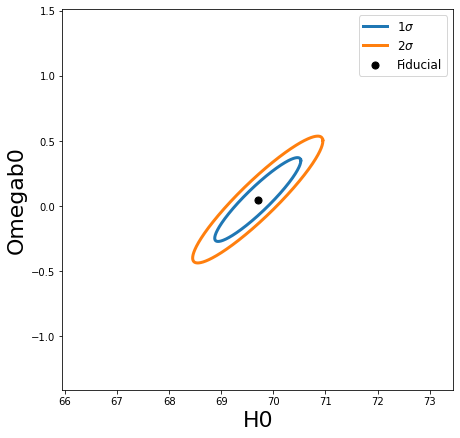

In [24]:
F = np.array([[F00,F01],
              [F01,F11]])
F_inv = np.linalg.inv(np.exp(F))
F_inv = np.array([[F_inv[0, 0], F_inv[1, 0]], [F_inv[0, 1], F_inv[1, 1]]])
F = np.linalg.inv(F_inv)

Phisher.Fisher(F, p['H0'], p['Omegab0'], 'H0','Omegab0', (7, 7))
plt.scatter(p['H0'], p['Omegab0'], label = 'Fiducial', color = 'k', s = 50)
plt.legend(prop = {'size': 12})
plt.margins(1.0);
plt.show()

$\large H_0$, $\large\Omega_m$

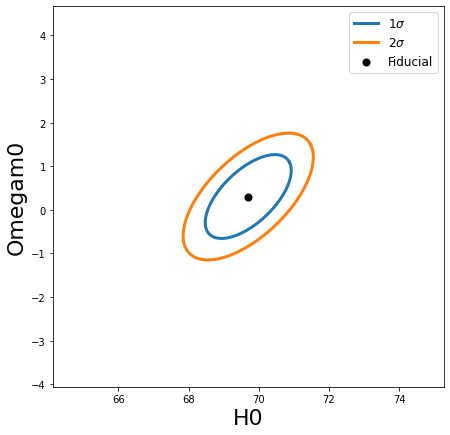

In [25]:
F = np.array([[F00,F02],
              [F02,F22]])
F_inv = np.linalg.inv(np.exp(F))
F_inv = np.array([[F_inv[0, 0], F_inv[1, 0]], [F_inv[0, 1], F_inv[1, 1]]])
F = np.linalg.inv(F_inv)

Phisher.Fisher(F, p['H0'], p['Omegam0'], 'H0','Omegam0', (7, 7))
plt.scatter(p['H0'], p['Omegam0'], label = 'Fiducial', color = 'k', s = 50)
plt.legend(prop = {'size': 12})
plt.margins(1.0);
plt.show()

$\large\Omega_b$, $\large\Omega_m$

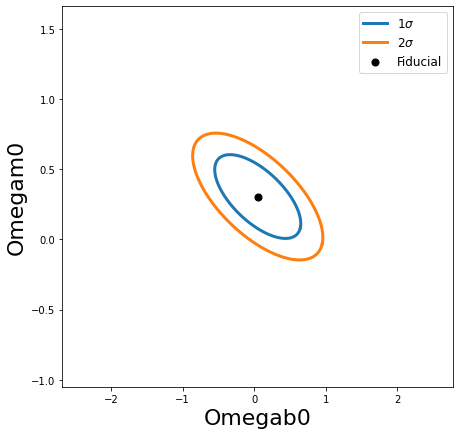

In [26]:
F = np.array([[F11,F12],
              [F12,F22]])
F_inv = np.linalg.inv(np.exp(F))
F_inv = np.array([[F_inv[0, 0], F_inv[1, 0]], [F_inv[0, 1], F_inv[1, 1]]])
F = np.linalg.inv(F_inv)

Phisher.Fisher(F, p['Omegab0'], p['Omegam0'], 'Omegab0','Omegam0', (7, 7))
plt.scatter(p['Omegab0'], p['Omegam0'], label = 'Fiducial', color = 'k', s = 50)
plt.legend(prop = {'size': 12})
plt.margins(1.0);
plt.show()